<p align="right">
    <img src="Capture.png" width="1100" height="1200" />

</p>


# Classifying basin‐scale stratigraphic geometries from subsurface formation tops with machine learning
### Jesse R. Pisel and Michael J. Pyrcz
#### Texas Institute for Discovery Education in Science, College of Natural Sciences, Cockrell School of Engineering, Jackson School of Geosciences
#### The University of Texas at Austin
**[Twitter](http://twitter.com/geologyjesse)** | **[GitHub](https://github.com/jessepisel)** | **[GoogleScholar](https://scholar.google.com/citations?user=Z4JzYgIAAAAJ&hl=en&oi=ao)** | **[LinkedIn](https://www.linkedin.com/in/jesse-pisel-70519430/)**



<tr>
  <td valign="top"><img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="225"></td> 
  <td valign="top"><img src="https://github.com/jessepisel/energy_analytics/blob/master/EA_logo.jpg?raw=true" width="250"></td>
  
<td valign="top"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/ConocoPhillips_Logo.svg/1200px-ConocoPhillips_Logo.svg.png" width="450"></td>

</tr>


## Executive Summary
**Problem**: Structure and thickness maps contoured from points are **non-unique** for onlap and truncation geometries

**Our Approach**: Teach a classifier to predict geometries for a _synthetic_ model, then transfer to "real world" data

**What We Learned**: Transfer learning works pretty well for this type of task

**Recommendations**: Useful for guided interpretation, and should be tried at different stratigraphic scales

If you think this is great read our 100% open-access paper:

https://onlinelibrary.wiley.com/doi/abs/10.1002/dep2.129 

And all the code is open-source:

https://github.com/jessepisel/stratal-geometries

## First the problem:

Let's walk through the conceptual idea behind the problem.

It's really tough to interpret if a formation is thinning because of truncation or thinning because of onlap. 

Think of it as the formation is thinning either at the top (truncation) or thinning on the bottom (onlap)

Let's see how everyone does with an example:

## Onlap or Truncation
<p align="right">
    <img src="a.jpg" width="400" height="400" />

</p>

## Onlap or Truncation
<p align="right">
    <img src="b.jpg" width="400" height="400" />

</p>

## How about cross sections?
<p align="right">
    <img src="axs.jpg" width="600" height="600" />

</p>

<p align="right">
    <img src="bxs.jpg" width="600" height="600" />

</p>

4 wells in each section with no V.E.

## How about another set of cross sections?
<p align="right">
    <img src="axsfull.jpg" width="600" height="600" />

</p>

<p align="right">
    <img src="bxsful.jpg" width="600" height="600" />

</p>

* 100 wells with 2x V.E.
* What made it easier for you with the second cross section? More data, vertical exaggeration, and comparing each vertical 1D profile to what is on either side of it?

## Our Approach:

* Can we use machine learning for this problem?
* It is a binary classification problem
* Need to include horizontal stratification
* How to build a training dataset when we don't know the classes downhole?

### How we did it
1. Build conceptual model of the subsurface for three classes
    * Truncation
    * Onlap
    * Horizontal stratification
2. Train machine learning classifer on _perfect_ models, measure uncertainty
3. Transfer classifier to real world dataset and compare to **ground truth** field geology

Let's start with training data

## Data Generation:

How to build conceptual models?

1. Use open source tools!
    * You can use any tools you have at your disposal
    * We chose open source because it's fast and easy
    * Bonus is we get to share it with everyone


<tr>
  <td valign="top"><img src="https://cepa.io/wp-content/uploads/2018/02/numpy-logo.png" width="200" /></td> 
  <td valign="top"><img src="https://numfocus.org/wp-content/uploads/2016/07/pandas-logo-300.png" width="200" /></td>
  <td valign="top"><img src="https://www.fatiando.org/verde/latest/_static/verde-logo.png" width="200" /></td>
  <td valign="top"><img src="https://matplotlib.org/_static/logo2_compressed.svg" width="200" /></td>
  <td valign="top"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/1200px-Scikit_learn_logo_small.svg.png" width="200" /></td>
  <td valign="top"><img src="https://www.fullstackpython.com/img/logos/scipy.png" width="200" /></td>

</tr>


#### More specifically:
1. Create geometries using sine waves (varying wavelength and amplitude)
2. Erode the geometries on each pass
3. Rotate the geometries

Let's run some code and see what the conceptual model looks like


In [1]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import verde as vd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## First define some global variables

In [2]:
# this creates dummy NAMES for the formations
NAMES = [
    "one",
    "two",
]  
# this is the number of tops you want in your training data
NUMBER_OF_LAYERS = 2  
# minimum value for top depths
SMALLEST = -6
# maximum value for top depths
LARGEST = 12
# number of steps between top depths
STEP = 2


### Next some functions that build our earth models

In [3]:
def truncation(smallest, largest, step, names, number_of_layers, j):
    """
    Creates truncated stratal geometries using a min, max, step, names and numbers of layers
    param smallest: the smallest integer value for stratigraphy
    param largest: the largest integer value for stratigraphy
    param step: the size of the step from smallest to largest
    param names: names of the layers as strings in a list
    param number_of_layers: number of layers to evaluate
    param j: float value that controls the wavelength of the sine curve
    """
    rolling = pd.DataFrame()
    j = np.round(j, decimals=3) + 0.5
    elevation_random = sorted(
        np.random.uniform(smallest, largest, number_of_layers - 1)
    )
    for i in range(len(names[0 : number_of_layers - 1])):

        basement = (
            0.001
            + (10) * np.sin(1 - np.arange(0, 40, 0.1) / (j * 2) + 0.001)
            + np.random.rand(400) / 5
        )
        elevation = (
            np.full(
                400,
                basement.max()
                + np.random.uniform(basement.min() / 2, basement.max() / 64, 1),
            )
            + np.random.rand(400) / 5
        )
        topbasement = np.where(basement > elevation, elevation, basement)

        rolling["zero"] = topbasement
        layer_elevation = (
            0.001
            + (10) * np.sin(1 - np.arange(0, 40, 0.1) / (j * 2) + 0.001)
            + abs(elevation_random[i])
            + np.random.rand(400) / 5
        )
        layer_elevation = np.where(
            layer_elevation < basement, basement, layer_elevation
        )
        layer_elevation = np.where(
            layer_elevation > elevation, elevation, layer_elevation
        )
        rolling[names[i]] = layer_elevation
    return rolling

In [4]:
def onlap(smallest, largest, step, names, number_of_layers, j):
    """
    Creates onlap stratal geometries using a min, max, step, names and numbers of layers
    param smallest: the smallest integer value for stratigraphy
    param largest: the largest integer value for stratigraphy
    param step: the size of the step from smallest to largest
    param names: names of the layers as strings in a list
    param number_of_layers: number of layers to evaluate
    param j: float value that controls the wavelength of the sine curve
    """
    rolling = pd.DataFrame()
    j = np.round(j, decimals=3) + 0.5
    elevation_random = sorted(
        np.random.uniform(smallest, largest, number_of_layers - 1)
    )
    for i in range(len(names[0 : number_of_layers - 1])):
        basement = (
            0.001
            + (10) * np.sin(1 - np.arange(0, 40, 0.1) / (j * 2) + 0.001)
            + np.random.rand(400) / 5
        )
        elevation = (
            np.full(
                400,
                basement.max()
                + np.random.uniform(basement.min() / 2, basement.max() / 64, 1),
            )
            + np.random.rand(400) / 5
        )
        topbasement = np.where(basement > elevation, elevation, basement)
        rolling["zero"] = topbasement
        strat_elevation = (
            np.full(400, elevation_random[i]) + np.random.rand(400) / 5
        )
        onlap = np.where(strat_elevation > basement, strat_elevation, basement)
        layer_elevation = np.where(onlap > elevation, elevation, onlap)
        rolling[names[i]] = layer_elevation
    return rolling

In [5]:
def horizontal(smallest, largest, step, names, number_of_layers):
    """
    Creates onlap stratal geometries using a min, max, step, names and numbers of layers
    param smallest: the smallest integer value for stratigraphy
    param largest: the largest integer value for stratigraphy
    param step: the size of the step from smallest to largest
    param names: names of the layers as strings in a list
    param number_of_layers: number of layers to evaluate
 
    """
    rolling = pd.DataFrame()
    elevation_random = sorted(
        np.random.uniform(smallest, largest, number_of_layers - 1)
    )
    for i in range(len(names[0 : number_of_layers - 1])):
        strat_elevation = (
            np.full(400, elevation_random[i]) + np.random.rand(400) / 5
        )
        basement = strat_elevation - abs(
            np.random.uniform(smallest, largest)
            + np.random.rand(400) / 5
        )
        elevation = (
            np.full(400, strat_elevation + elevation_random[i])
            + np.random.rand(400) / 5
        )
        topbasement = np.where(basement > elevation, elevation, basement)
        layer_elevation = np.where(
            strat_elevation > elevation, elevation, strat_elevation
        )
        rolling["zero"] = topbasement
        rolling[names[i]] = layer_elevation
    return rolling

### Now some functions to build out features

In [6]:
def rotation(dataframe, j):
    """
    Creates spatial samples and rotates them in the xy plane
    param dataframe: dataframe output from stratigraphy generation
    param j: controls the rotation of the dataset 0 is no rotation
    """
    x = np.arange(0, 40, 0.1)
    y = np.random.randint(0, 10, len(x))
    # this is the rotation of the generated data
    if j % 0.2 > 0.1:
        dataframe["ex"] = x * np.cos(-j / 2) - y * np.sin(-j / 2)
        dataframe["ey"] = y * np.cos(-j / 2) - x * np.sin(-j / 2)
    else:
        dataframe["ex"] = x * np.cos(j / 2) - y * np.sin(j / 2)
        dataframe["ey"] = y * np.cos(j / 2) - x * np.sin(j / 2)
    return dataframe

In [7]:
def depth_to_thickness(neighborhood, dataframe):
    """
    Converts the depth dataframe from the adjacent wells function to thicknesses
    param neighborhood: dataframe output from `adjacent_wells`
    param dataframe: dataframe output from function `missing`
    """
    locations = pd.DataFrame()
    df = pd.DataFrame()
    thicknesses = neighborhood.diff(axis=1)
    thicknesses[thicknesses < 0] = 0
    thicknesses.drop(columns="zero", inplace=True)
    locations = pd.concat((locations, dataframe.iloc[:, -2:]))
    df = pd.concat((df, thicknesses))
    return df, locations
  
    

In [8]:
def feature_list(no_of_neighbors):
    """
    Creates a list of features given number of adjacent wells
    param no_of_neighbors: number of adjacent wells used in feature engineering
    """
    print("Getting the features")
    initial = ["thickness", "thickness natural log", "thickness power"]
    features = []
    for item in initial:
        features.append(item)
        for i in range(1, no_of_neighbors + 1):
            features.append(item + " neighbor " + str(i))
    features.append(["x location", "y location", "class"])
    return list(flatten(features))

In [9]:
def flatten(container):
    "Flattens lists"
    for i in container:
        if isinstance(i, (list, tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [10]:
np.random.seed(18)
truncated = truncation(SMALLEST, LARGEST, STEP, NAMES, NUMBER_OF_LAYERS, 2) # 2 == wavelength
trunc_rotated = rotation(truncated, 10) # 10 == rotation
trunc_thickness, trunc_locations = depth_to_thickness(trunc_rotated, trunc_rotated)

In [11]:
np.random.seed(18)
onlapping = onlap(SMALLEST, LARGEST, STEP, NAMES, NUMBER_OF_LAYERS, 10) # 10 == wavelength
onlap_rotated = rotation(onlapping, 1) # 1 == rotation 
onlap_thickness, onlap_locations = depth_to_thickness(onlap_rotated, onlap_rotated)

In [12]:
np.random.seed(18)
horizontally = horizontal(SMALLEST, LARGEST, STEP, NAMES, NUMBER_OF_LAYERS)
horiz_rotated = rotation(horizontally, 1)
horiz_thickness, horiz_locations = depth_to_thickness(horiz_rotated, horiz_rotated)

Text(0.5, 1.0, 'Truncation Thickness')

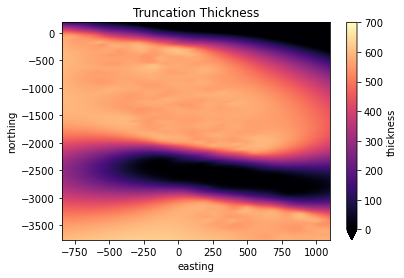

In [13]:
spline = vd.Spline()
spline.fit((trunc_locations.ex*100, trunc_locations.ey*100), trunc_thickness.one*100)
AUIGRID = spline.grid(spacing=1, data_names=["thickness"])
AUIGRID.thickness.plot.pcolormesh(cmap="magma", vmin=0, vmax=700)
plt.title("Truncation Thickness")

Text(0.5, 1.0, 'Truncation Structure')

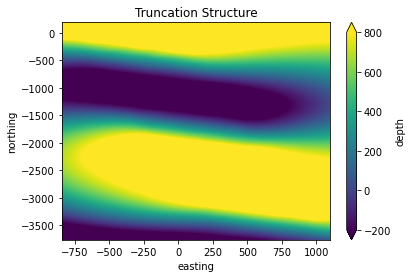

In [14]:
spline = vd.Spline()
spline.fit((trunc_locations.ex*100, trunc_locations.ey*100), trunc_rotated.one*100)
AUSGRID = spline.grid(spacing=1, data_names=["depth"])
AUSGRID.depth.plot.pcolormesh(cmap="viridis", vmin=-200, vmax=800)
plt.title("Truncation Structure")

Text(0.5, 1.0, 'Onlap Thickness')

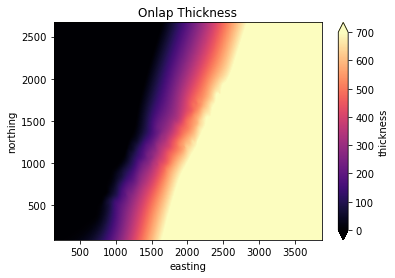

In [15]:
spline = vd.Spline()
spline.fit((onlap_locations.ex*100, onlap_locations.ey*100), onlap_thickness.one*100)
OLIGRID = spline.grid(spacing=1, data_names=["thickness"])
OLIGRID.thickness.plot.pcolormesh(cmap="magma", vmin=0, vmax=700)
plt.title("Onlap Thickness")

Text(0.5, 1.0, 'Onlap Structure')

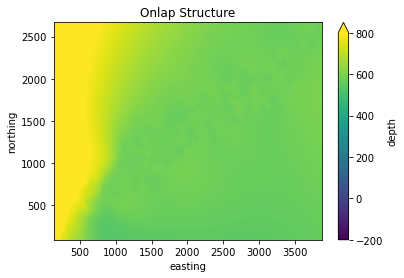

In [16]:
spline = vd.Spline()
spline.fit((onlap_locations.ex*100, onlap_locations.ey*100), onlap_rotated.one*100)
OLSGRID = spline.grid(spacing=1, data_names=["depth"])
OLSGRID.depth.plot.pcolormesh(cmap="viridis", vmin=-200, vmax=800)
plt.title("Onlap Structure")

## Feature Engineering

We have a conceptual model with features:
* X location
* Y location
* Depth to top

<p float="center">
  <img src="initfeat.jpg" width="225" />   
</p>

#### Feature Engineering helped us humans in our cross sections above let's add some engineered features

* Calculate thickness at each point
* Log transform of thickness
* Power transform of thickness
* The 3 features above for each nearby well (wells don't live in a spatial vacuum)
* Add in some missing at random tops (similar to real world situations)

<p float="center">
  <img src="engfeat.jpg" width="900" />   

</p>

Let's look at `01_training_data.ipynb`

## Model Selection

* We now have a dataset we can train a machine learning classifier on!
* How do we measure accuracy for this?
* Let's use the Jaccard Similarity Metric
    * "the size of the intersection divided by the size of the union of two label sets...compares a set of predicted labels ... to the true values"
* Value of 1 == 100% accuracy
* Value of 0 == 0% accuracy

Let's pick a few classification models and see how they do "out of the box"

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score

In [25]:
# read the data we made
dataset = pd.read_csv(r'stratigraphic_geometry_dataset.csv', index_col=[0])
dataset.head()

,thickness,thickness neighbor 1,thickness neighbor 2,thickness neighbor 3,thickness neighbor 4,thickness neighbor 5,thickness neighbor 6,thickness neighbor 7,thickness neighbor 8,thickness neighbor 9,...,thickness power neighbor 393,thickness power neighbor 394,thickness power neighbor 395,thickness power neighbor 396,thickness power neighbor 397,thickness power neighbor 398,thickness power neighbor 399,x location,y location,class
0,0.989164,0.997804,0.145011,0.140579,0.989637,0.997083,0.151415,0.984158,0.132947,0.996989,...,0.469745,0.001928,0.002412,0.002352,0.000496,1.000000,0.000000,0.025438,0.804583,truncation
1,0.993069,0.158518,0.997046,0.125418,0.099472,0.997083,0.151415,0.984158,0.997798,0.135135,...,0.469745,0.002412,0.001928,0.002352,0.000496,1.000000,0.000000,0.000000,1.000000,truncation
2,0.997804,0.996779,0.996813,0.989164,0.148022,0.984689,0.135106,0.144972,0.118781,0.125444,...,0.469745,0.001928,0.002412,0.002352,0.000496,1.000000,0.000000,0.023262,0.850931,truncation
3,0.987700,0.989470,0.982919,0.140579,0.141552,0.981977,0.982368,0.989164,0.141371,0.147452,...,0.001928,0.469745,0.002352,0.002412,0.000496,0.005819,0.352576,0.046525,0.701862,truncation
4,0.158518,0.993069,0.997046,0.103070,0.121915,0.997083,0.151415,0.984158,0.132947,0.998014,...,0.469745,0.002412,0.001928,0.002352,0.000496,1.000000,0.000000,0.007172,0.995704,truncation


In [26]:
# Set number of wells in vicinity
wells_in_vicinity = 0
flat_features = feature_list(wells_in_vicinity)
subset = dataset[flat_features]

# split the dataset into test/train subsets
X_train, X_test, y_train, y_test = train_test_split(
        subset.drop("class", axis=1), subset["class"], test_size=0.2, random_state=86,
    )
X_train

Getting the features


,thickness,thickness natural log,thickness power,x location,y location
191,0.101742,0.448287,6.952262e-10,0.268861,0.554104
197,0.996283,0.999164,9.638883e-01,0.493734,0.666667
257,0.971061,0.981027,8.375555e-01,0.337916,0.670609
271,0.419412,0.795133,1.684264e-04,0.379617,0.363266
372,0.000000,0.000000,0.000000e+00,0.849545,0.692486
...,...,...,...,...,...
307,0.000000,0.556125,0.000000e+00,0.275040,0.513763
364,0.976427,0.995755,7.877637e-01,0.145473,0.410302
300,0.000000,0.611820,0.000000e+00,0.375847,0.731893
64,0.018271,0.034535,3.246879e-06,0.831884,0.268978


### Let's see how random guessing performs for a baseline

In [19]:
# random
np.random.seed(18)
y_pred = np.random.choice(['truncation', 'onlap', 'horizontal'], len(y_test))
weighted_jc_score = jaccard_score(y_test, y_pred, average='weighted')
print(f'Accuracy for each class is {jaccard_score(y_test, y_pred, average=None)}')
print(f'Average weighted accuracy is {weighted_jc_score:.2f}')

Accuracy for each class is [0.20437956 0.20804954 0.18985372]
Average weighted accuracy is 0.20


### Now a support vector classifier

In [20]:
# SVM
svmclf = svm.SVC()
svmclf.fit(X_train, y_train)
y_pred = svmclf.predict(X_test)
weighted_jc_score = jaccard_score(y_test, y_pred, average='weighted')
print(f'Accuracy for each class is {jaccard_score(y_test, y_pred, average=None)}')
print(f'Average weighted accuracy is {weighted_jc_score:.2f}')

Accuracy for each class is [0.75636212 0.48589126 0.30998249]
Average weighted accuracy is 0.52


### How about a decision tree?

In [21]:
# Decision Tree
dtclf = DecisionTreeClassifier()
dtclf.fit(X_train, y_train)
y_pred = dtclf.predict(X_test)
weighted_jc_score = jaccard_score(y_test, y_pred, average='weighted')
print(f'Accuracy for each class is {jaccard_score(y_test, y_pred, average=None)}')
print(f'Average weighted accuracy is {weighted_jc_score:.2f}')

Accuracy for each class is [0.9218509  0.72567923 0.73936652]
Average weighted accuracy is 0.79


### A random forest

In [22]:
# Random Forest
rfclf = RandomForestClassifier()
rfclf.fit(X_train, y_train)
y_pred = rfclf.predict(X_test)
weighted_jc_score = jaccard_score(y_test, y_pred, average='weighted')
print(f'Accuracy for each class is {jaccard_score(y_test, y_pred, average=None)}')
print(f'Average weighted accuracy is {weighted_jc_score:.2f}')

Accuracy for each class is [0.93536711 0.76908924 0.7819583 ]
Average weighted accuracy is 0.83


### What about boosting?

In [23]:
# AdaBoost
abclf = AdaBoostClassifier()
abclf.fit(X_train, y_train)
y_pred = abclf.predict(X_test)
weighted_jc_score = jaccard_score(y_test, y_pred, average='weighted')
print(f'Accuracy for each class is {jaccard_score(y_test, y_pred, average=None)}')
print(f'Average weighted accuracy is {weighted_jc_score:.2f}')

Accuracy for each class is [0.7580574  0.36306672 0.39484199]
Average weighted accuracy is 0.50


### What about a k-neighbors classifier?

In [24]:
# KNN
knclf = KNeighborsClassifier()
knclf.fit(X_train, y_train)
y_pred = knclf.predict(X_test)
weighted_jc_score = jaccard_score(y_test, y_pred, average='weighted')
print(f'Accuracy for each class is {jaccard_score(y_test, y_pred, average=None)}')
print(f'Average weighted accuracy is {weighted_jc_score:.2f}')

Accuracy for each class is [0.72285464 0.58974359 0.53508412]
Average weighted accuracy is 0.61


## Active learning grid search

* **Random forest** has the best initial accuracy
* Let's tune the hyperparameters for it
* Hyperparameters are chosen before training begins (user specified)
* Grid search for parameters with 5 fold cross validation
* We need a certainty measure to stop training before it overfits

<p align="right">
    <img src="gridsearch.jpg" width="400" height="400" />

</p>

`03_active_learning_grid_search.ipynb`

## How does the classifier perform?

* We split our generated dataset into **test/train** subsets
* How confused is our model? 
* 88.4% Accuracy, 72.8% certainty
<p align="right">
    <img src="confusion.jpg" width="400" height="400" />
</p>


## Now what?

* How do we translate from predictions on our synthetic data to "real world" data?
* Find a subsurface dataset and process it in the same manner
    * Calculate formation thicknesses
    * Feature Engineering (log and power transforms, wells in vicinity)
* Make predictions and visualize with classifier certainty


## Real World Predictions

<img src = "https://content.govdelivery.com/attachments/fancy_images/WYSGS/2015/07/566177/banner-600_original.jpg" width="500" />

* Subsurface data from the Wyoming State Geological Survey (Lynds and Lichtner, 2016)
* Eastern Greater Green River Basin
* Subsurface formation tops picked:
    * Fort Union
    * Lance Formation
    * Fox Hills Sandstone

<p align="right">
    <img src="overviewmap.jpg" width="600" height="600" />

</p>

## Spatial Results
### Geologic Interpretation

<p align="right">
    <img src="lance.jpg" width="600" height="600" />
</p>

* Lance Formation
    * Central Great Divide Basin: conformable with Fox Hills Formation and Fort Union Formation
    * The band of wells classified as onlap interpreted as a wide basin margin during deposition
    * Truncation swath includes Wamsutter Arch, Rock Springs Uplift, Dad Arch, on trend with Sierra Madre Uplift and Wind River Range

<p align="right">
    <img src="ftunion.jpg" width="600" height="600" />
    <img src="certainty.jpg" width="600" height="600" />
    
</p>

* Fort Union Formation
    * Mostly horizontally stratified
    * Truncation and onlap mixed along west end of Wamsutter Arch matches field mapping
    * Also Almond/Lewis age paleohigh
    * Washakie Basin truncation (ne-sw) follows regional trends, truncation on Cherokee Arch
    * Tough in this area because of geometry similarity, but now a measure of confidence

## Data Science Interpretation

* Geolocially reasonable results
* Uncertainty identifies areas an expert should reevaluate
* What do the predictions look in lower dimensional space?
* Dimension reduction with t-distributed stochastic neighbor embedding (t-SNE)

<p align="right">
    <img src="tsne.jpg" width="600" height="600" />
</p>

* Horizontal stratification clusters in a distinct region
* Overlap between onlap and truncation in this space
    * Intuitive since they look the same 

* What does the synthetic dataset tell us about each class?
* Compare the distribution of one feature and one sample to the distribution of the entire class
* Measure similarity with the K-L divergence
* Lower K-L divergence values == more similar to that class

<p align="right">
    <img src="kl-divergence.jpg" width="200" height="200" />
</p>
* Increasing wells in vicinity == decreasing divergence

## What we Learned
<p align="right">
    <img src="models.png" width="600" height="600" />
</p>



#### But some models help us stop arm waving
<p align="right">
    <img src="armwaving.jpg" width="600" height="600" />
</p>



#### Yours truly arm waving on the Rock Springs Uplift

<p align="right">
    <img src="waving.jpg" width="400" />
</p>



## What we learned

* The classification model is **useful**
* High classification accuracy is possible on the training dataset
* Qualitatively does a reasonable job in the real world
* **Classifications are consistent with spot checks and previous interpretations**
* Still areas with misclassifications
* Certainty measure is useful to interpret the predictions

## Recommendations

#### For this model
* Classification model aids geologists in searching for unique patterns
* Interpret geometries across a basin in seconds
* Uncertain areas can then be interrogated further
* Try this at different scales (bedset to sequence)

#### In General
* Transfer learning has tremendous opportunities in the subsurface
* Subsurface experts **need** to be fluent in data/stats/ML/AI  
* The fusion of on the ground and data driven geoscience research is already here


* Examples of what UT **Freshmen** computer scientists are doing:
    * Automatic well-log correlation (in review)
    * Automatic curve aliasing (in prep, open source)
    * Satellite images to geologic maps (proof of concept works)
    * Well path optimization (Reinforcement learning proof of concept)
    * 3D kriging (geostatspy)
    * Spatial debiasing (proof of concept)

## Thanks for coming! Let's have a discussion!
#### Want to work together with the Energy Analytics team? Get in touch jesse.pisel@austin.utexas.edu